# Classificação de elementos transponíveis do DNA da espécie *Zea mays*

Projeto final da Disciplina: Introdução à bioninformática. ICMC-USP, segundo semestre de 2024.

Realizado pelos alunos:
- Arthur Grillo Queiroz Cabral - NUSP: 12690500
- Felipe Carneiro Machado - NUSP: 14569373
- Pedro Calciolari Jardim - NUPS: 11233668


Neste projeto, foi desenvolvido código para a classificação em 6 classes (LINE, SINE, LTR, Helitron, TIR, MITE) de elementos transponíveis do genoma da planta *Zea mays*, adquiridos da base de dados *Atlas dos elementos transponíveis*, disponível em http://apte.cp.utfpr.edu.br/download.

## Primeira fase: Download e organização da base de dados
Primeiramente, foram baixados os arquivos *.gff3*, os quais continham informação sobre a localização dos elementos transponíveis no genoma de referência da espécie.
O projeto especificou que apenas TEs de *strand* positiva deveriam ser avaliados, assim, o seguinte script foi utilizado para realizar essa filtragem.

*Obs: A estrutura de diretórios do projeto requer a pasta *data* e algumas outras que aparecerão no código, sua criação é indispensável para executar este notebook.

In [14]:
import pandas as pd
from glob import glob


def filter_gff3(filename):
    # Anota as colunas do .gff3
    columns = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]

    # Leitura com pandas
    df = pd.read_csv(f"data/raw_gff3/{filename}", sep="\t", comment="#", names=columns)

    # Gera dicionario a partir dos atributos do .gff3
    def parse_attributes(attributes):
        return dict(item.split("=") for item in attributes.split(";"))
    df["parsed_attributes"] = df["attributes"].apply(parse_attributes)

    # Apenas strands positivas
    filtered = df[df["strand"] == "+"]

    # csv filtrado
    filtered.to_csv(f"data/positive_csv/{filename.split("/")[-1][:-5]}.csv")

for uri in glob("data/raw_gff3/*"):
    filter_gff3(uri.split("/")[-1])


Realizada a filtragem, é necessárrio fazer o download, através do NCBI, das sequências de DNA. Uma abordagem talvez mais rápida consiste em fazer o download completo dos cromossomos, e apenas buscar dentro dos arquivos, evitando overhead de requisições. Porém, cada cromossosmo tem vários GB de dados, não sendo possível em minhas condições realizar o download na íntegra. Logo, utilizei o BioPython para realizar requisições individuais para cada sequência.

In [9]:
!pip install biopython

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for biopython from https://files.pythonhosted.org/packages/46/37/7db2bcbb396edba3f767dd89ac23ef5adc35c7a92ef3912c06d1e71469e1/biopython-1.84-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 9.6 MB/s eta 0:00:000m eta 0:00:010:00:01


In [13]:
from Bio import Entrez, SeqIO
from urllib.error import HTTPError
from random import choices

chromossome_id_map = {f"{i}" : f"LR6188{73 + i}" for i in range(1, 11)} # Relaciona cromossomo com codigo de acesso
Entrez.email = "seu_email@domain.com" # NCBI requer identificacao

# Para cada .csv filtrado
for uri in ["data/positive_csv/TEAnnotationFinal_Helitron.csv", "data/positive_csv/TEAnnotationFinal_LTR.csv"]:
    print(f"reading from {uri}")
    # DataFrame para armazenar as sequencias lidas
    seq_df = pd.DataFrame(columns=["Chromossome", "Sequence", "Class"])
    # Usa DataFrame para armazenar dados das sequencias
    df =  pd.read_csv(uri)
    # Classe
    te_class = uri.split("_")[-1].split(".")[0]
    df.reset_index()
    # O tamanho da base de dados tornou impossível baixá-la na integra, foram baixados apenas 2000 de cada classe
    for i in choices(list(range(0, len(df))), k=2000):
        entry = df.loc[i]
        chromossome = entry["seqid"] # Cromossomo
        seq_id = chromossome_id_map.get(entry["seqid"], None) # Codigo de acesso 
        # Haviam alguns cromossomos estranhos, optei por ignora-los
        if seq_id == None:
            continue
        start = str(entry["start"])
        end = str(entry["end"])
        # Houveram alguns erros de conexao, optei por ignora-los
        try:
            # Requisicao ao NCBI
            stream = Entrez.efetch(db="nucleotide", 
                            id=seq_id, 
                            rettype="fasta", 
                            retmode="text", 
                            strand="1",
                            seq_start=start,
                            seq_stop=end
                            )
            seq = str(SeqIO.read(stream, "fasta").seq)
        except HTTPError as e:
            print(f"Exception raised in row {i} of {te_class}")
            print(e)
            print("Continuing")

        print(f"Read sequence : {seq_id} | {start} -> {end}")
        # Adiciona ao DataFrame
        seq_df = pd.concat([seq_df, pd.DataFrame({
            "Chromossome" : [chromossome],
            "Sequence" : [seq],
            "Class" : [te_class]
        })], ignore_index=True)
        stream.close()
    # Armazena como .csv
    seq_df.to_csv(f"data/dataset/{te_class}_dataset.csv")


reading from data/positive_csv/TEAnnotationFinal_Helitron.csv


FileNotFoundError: [Errno 2] No such file or directory: 'data/positive_csv/TEAnnotationFinal_Helitron.csv'

## Extração de Features
Para extrair feature das sequências de DNA, foi utilizado o pacote MathFeature, o qual contém mais de uma dezena de métodos para esse fim. Busca na literatura indicou que o uso de frequência de k-mers é adequada como feature para classificação de TEs. Testes empíricos com este e outros métodos do pacote confirmaram esta hipótese. Foi criado um dataset combinando a frequencia de 2-mers, 3-mers e 4-mers. Segue abaixo o script para tal.

In [ ]:
from subprocess import Popen
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import Bio.SeqIO as SeqIO
from glob import glob
import pandas as pd
import os


for ds_name in [f"{i}MER" for i in range(2, 5)]:
    # Criacao de pastas
    try:
        os.mkdir(f"data/{ds_name}_data")
    except:
        pass
    # Cria o arquivo output
    open(f"data/{ds_name}_data/{ds_name}.csv", "w").close()
    for uri in sorted(glob("data/dataset/*")):       
        class_name = uri.split("/")[-1].split("_")[0] # Classe
        # O MathFeature Requer input em formato fasta, logo cria um arquivo temporario
        fout_uri = f"data/temp_fasta/{class_name}_temp.fasta" 
        fout = open(fout_uri, "w")
        # Le csv da classe
        df = pd.read_csv(uri)
        seq_list = []
        for i, row in df.iterrows():
                seq = Seq(row["Sequence"])
                if not "N" in seq: # Checa se a sequencia nao possui nucleotideos indefinidos (gera erros com o MathFeature)
                        seq_list.append(SeqRecord(Seq(row["Sequence"]), id=str(i), description=""))
        SeqIO.write(seq_list, fout ,"fasta")
        fout.close()

        # Executa a extracao de features
        process = Popen(["python", "MathFeature/methods/k-mers.py", 
        "-i", fout_uri, # Input
        "-o", f"data/{ds_name}_data/{ds_name}.csv", # Output
        "-l", class_name, # Label no csv, classe do TE
        "--seq", "1", # Identifica que eh DNA
        "-k", str(i) # k de k-mer 
        ])
        process.wait()


# Limpa e junta os datasets

ds_list = ["2MER", "3MER", "4MER"]

# Leitura
df_list = [pd.read_csv(f"data/{method}_data/{method}.csv") for method in ds_list]
# Remove linhas de cabecalho repetidas
df_list = [df[df.apply(lambda row : row["nameseq"] != "nameseq", axis=1)] for df in df_list]
# Remove inf
df_list = [df[~df.isin(["inf", "-inf"]).any(axis=1)] for df in df_list]

first_df = df_list[0]
reduced_df = [df.drop(["label", "nameseq"], axis=1) for df in df_list[1:]]

final_df = pd.concat([first_df] + reduced_df, axis=1)
filename = "+".join(ds_list)
# Salva o arquivo final para classificacao
final_df.to_csv(f"data/classification_data/{filename}.csv")



###################################################################################
######################## Feature Extraction: k-mer scheme #########################
##########   Arguments: python3.5 -i input -o output -l label -k kmer   ###########
##########               Author: Robson Parmezan Bonidia                ###########
###################################################################################




## Classificação

Exploramos dois algoritmos populares para tarefas de classificação: Linear Discriminant Analysis (LDA) e Support Vector Machine (SVM). Ambos são métodos supervisionados, mas utilizam abordagens diferentes para modelar e separar as classes nos dados. O LDA busca encontrar uma projeção linear dos dados que maximize a separação entre as classes, enquanto o SVM procura um hiperplano que maximiza a margem entre as classes, podendo também lidar com problemas não lineares por meio de kernels.

A avaliação de desempenho dos modelos é feita por meio da curva Precision-Recall, que permite analisar como os modelos se comportam em termos de precisão e recall para diferentes limiares de decisão. Nesta seção, serão discutidos os dois códigos que implementam esses algoritmos, seguidos de uma comparação detalhada entre os resultados obtidos para cada abordagem.

## LDA
O primeiro código implementa uma análise de classificação utilizando o Linear Discriminant Analysis (LDA). O LDA é um método estatístico amplamente utilizado para redução de dimensionalidade e classificação supervisionada.

Ele é um classificador que assume que as classes têm distribuições normais com a mesma matriz de covariância. Isso significa que ele é mais eficaz quando as classes estão bem separadas no espaço de características.

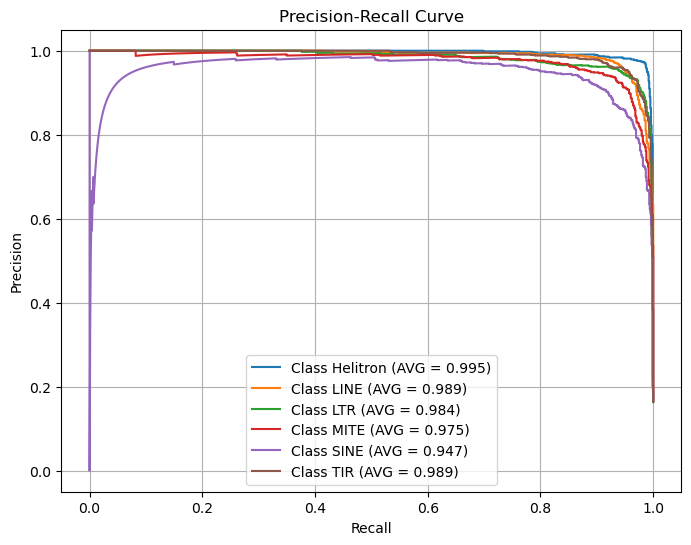

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.svm as svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# Leitura dos dados
df = pd.read_csv("data/classification_data/2MER+3MER+4MER.csv").drop("nameseq", axis=1)
x = df.drop("label", axis=1)
tgt_df = df["label"]

X = x.to_numpy(dtype=np.float32)
Y = tgt_df.to_numpy()
class_names = sorted(np.unique(Y))
y_encoded = LabelEncoder().fit_transform(Y)

class_mapping = dict(zip(range(1, 7), sorted(class_names)))


# Teste e treino
X_train, X_test, Y_train, Y_test = train_test_split(X, y_encoded, train_size=0.5)
clf = LinearDiscriminantAnalysis().fit(X_train, Y_train)
clf.score(X_test, Y_test)

import matplotlib.pyplot as plt


y_scores = clf.predict_proba(X_test)
precision = {}
recall = {}
avg_precision ={}

for i, class_name in enumerate(class_names):
    # Binary ground truth for the current class (one-vs-all)
    y_test_binary = (Y_test == i).astype(int)
    
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary, y_scores[:, i])
    avg_precision[i] = average_precision_score(y_test_binary, y_scores[:, i])

#print(list(zip(precision[1].astype(float), recall[1].astype(float))))

# 5. Plot Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    plt.plot(recall[i], precision[i], label=f'Class {class_name} (AVG = {avg_precision[i]:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


## SVM
O segundo código utiliza um Support Vector Machine (**SVM**) para a tarefa de classificação.

O **SVM**, especialmente quando usado com o kernel Radial Basis Function (**RBF**), tem a capacidade de modelar relações não lineares entre as classes, tornando-o mais robusto em problemas onde a separação linear das classes não é possível. A literatura de aprendizado de máquina aplicado a dados genéticos, e especificamente **TEs**, apresenta-o como um classificador eficaz para essa tarefa.

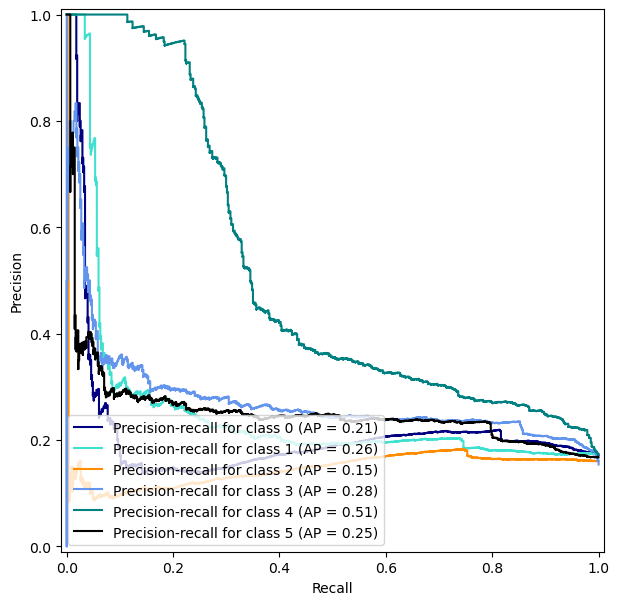

In [3]:
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.svm as svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Leitura dos dados
df = pd.read_csv("data/classification_data/2MER+3MER+4MER.csv").drop("nameseq", axis=1)

repetidas = []
for i in df.columns:
    if("." in i or i.startswith("Unnamed") or len(i) == 1):
        #df = df.drop(i, axis=1)
        repetidas.append(i)

df = df.drop(repetidas, axis=1)

x = df.drop("label", axis=1)
tgt_df = df["label"]

X = x.to_numpy(dtype=np.float32)

Y = tgt_df.to_numpy()
class_names = sorted(np.unique(Y))
y_encoded = label_binarize(Y, classes=class_names)
#y_encoded = LabelEncoder().fit_transform(Y)

class_mapping = dict(zip(range(1, 7), sorted(class_names)))


# Teste e treino
X_train, X_test, Y_train, Y_test = train_test_split(X, y_encoded, train_size=0.7)


param_grid = {
     'C': [0.1, 1, 10, 100],
     'gamma': [1, 0.1, 0.01],
     'kernel': ['rbf'],
     "decision_function_shape" : ["ovo", "ovr"]
 }

classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(),  svm.SVC())
)

classifier.fit(X_train, Y_train)

y_score = classifier.decision_function(X_test)

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal", "black"])

_, ax = plt.subplots(figsize=(7, 8))

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(6):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])


for i, color in zip(range(6), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

plt.show()

## Comparação

Pelas curvas de ***Precision-Recall*** podemos fazer uma comparação entre os dois métodos.

Para este cenário, onde as características dos dados parecem ser mais adequadas a uma separação linear, o **LDA** obteve melhores resultados, com curvas mais altas e constantes em todas as classes. Esse desempenho superior pode ser explicado pela simplicidade do modelo e pela sua capacidade de encontrar uma projeção ótima para a separação das classes, o que resulta em maior precisão e recall.

Por outro lado, o **SVM**, embora muito eficiente para tarefas de classificação complexas, não conseguiu alcançar o mesmo nível de desempenho nas curvas ***Precision-Recall*** para este conjunto de dados. Apesar de ser recomendado pela literatura, ele apresentou flutuações nas curvas de precisão e recall, o que sugere que ele pode não ter sido capaz de se adaptar tão bem à estrutura dos dados neste caso específico. 

Portanto, vale relembrar a importância de se considerar as características dos dados ao escolher o modelo de classificação. Embora o **SVM** seja amplamente utilizado e seja a escolha preferencial para esse tipo de problema, o **LDA** demonstrou ser mais adequado para este caso específico.